This document explores the homogeneity of samples generated from two different distributions.

**Purpose:**

1.  **Sample Generation:** Generate two distinct samples from `cosine` and `hypsecant` distributions, and then concatenate them into a single sample.
2.  **Homogeneity Test:** Implement a statistical test (empirical bridge) to assess the homogeneity of the combined sample. Theoretically, this test should indicate non-homogeneity due to the sample's construction from different distributions.
3.  **Robustness Check:** Evaluate the test's behavior and power by constructing additional samples. This is done by raising the original samples to the power of 2 and 4, and then re-running the homogeneity test to see how the test's conclusions change under these transformations.

In [95]:
from scipy.stats import cosine, hypsecant, kstwobign
import numpy as np
import matplotlib.pyplot as plt

 n1 = 110, distr1=cosine, distr2=hypsecant

In [96]:
N = 200
n1 = 110
n2 = N - n1

In [97]:
def generate_sample():
  sample_1 = cosine.rvs(loc=0, scale=1, size=n1)
  sample_2 = hypsecant.rvs(loc=0, scale=1, size=n2)

  return np.concatenate((sample_1, sample_2), axis=0)

In [98]:
def plot_sample(sample, title):
  fig, ax = plt.subplots()

  ax.plot(sample)
  ax.set_title(title)
  ax.set_xlabel("Index")
  ax.set_ylabel("Value")

  ax.axhline(y=np.mean(sample), color='red', label="Sample mean")
  ax.axvline(x=n1, color="green", label="Breakpoint", linestyle="--")

  plt.legend()

Empirical bridge process it a stohastic process

Given the sample $X_0, X_1, \dots, X_n$ we define its residuals as:
$$ e_i = X_i - \bar{X} $$, where $\bar{X}$ is the mean of the sample \
The cumulative sum of residuals is:
$$ S_k = \sum_{i=0}^k e_i$$
The Empirical Bridge Process $B_n(t)$ is a continuous-time process defined for $t \in [0, 1]$:
$$ B_n(t) = \frac{S_{\lfloor t\cdot n \rfloor}}{\sqrt{n}\cdot\hat{\sigma}}$$, where $\hat{\sigma}^2$ is the sample variance
\
\
Key property is that $S_0 = 0$ and $S_n = \sum\limits_{i=0}^n e_i = \sum\limits_{i=0}^{n}X_i - n \cdot \frac{\sum\limits_{i=0}^{n}X_i}{n} = 0$\
So $B_n(0) = B_n(1) = 0$



In [99]:
def empirical_bridge(sample):
  I = np.asarray(sample, dtype=float)
  n = len(I)
  if n == 0:
      raise ValueError("The array is empty")

  mean = I.mean()
  std = I.std()
  residuals = I - mean

  if std == 0 or n == 1:
      emp_bridge = np.zeros(n)
      return emp_bridge

  emp_bridge = np.cumsum(residuals)
  emp_bridge = np.insert(emp_bridge, 0, 0)
  emp_bridge = emp_bridge / (np.sqrt(n) * std)

  return emp_bridge

In [100]:
def plot_empirical_bridge(emp_bridge, title):
  fig, ax = plt.subplots()
  ax.plot(np.linspace(0, 1, len(emp_bridge)), emp_bridge)
  ax.axhline(y=0, color='red')
  ax.set_title(title)
  ax.set_xlabel("k/N")
  ax.set_ylabel("Value")
  ax.axvline(x=n1/N, color="green", label="Breakpoint", linestyle="--")

  ax.legend()

  plt.show()

Building a statistical test to identify the breakpoint\
**H0:** Whole sample is homogeneous (no change)\
**H1:** There is a change-point in the sample\
Change-point statistic is
$$ T_n = \max_{1 \leq k \leq n} \frac{|S_k|}{\sqrt{n}\cdot \hat{\sigma}} $$
Under H0 hypothesis:
$$ T_n  \xrightarrow{d} \sup_{0\leq t \leq 1}{|B(t)|}$$
This equation means, that as $n \to \infty$, then the statistic $T_n$ starts behaving more like the supremum of Brownian bridge process\
The distribution of the supremum of Brownian bridge process is the Kolmogorov-Smirnov distribution


---

p-value is the probability of observing test statistic as extreme as the given (or even more extreme) under the assumption on H0 (sample ifs homogeneous)\
So is p-value is big, than we accept H0. Otherwise reject it, because this test statistic seems very unlikely.

So:
$$ \text{p-value} = P(x > T_n | H_0\text{ is true})$$

If $T_n$ is bigger than critical value, then p-value is less, than significance level and we reject H0
---

For a Kolmogorov-Smirnov distirbution the survival function is:
$$ P(\sup{|B(t)|} > T_n | H_0\text{ is true}) = 2\cdot\sum\limits_{m=1}^{\infty}(-1)^{m - 1}e^{-2m^2x^2}$$


In [101]:
def calculate_test_statistic(emp_bridge):
  return np.max(np.abs(emp_bridge))

def calculate_p_value(test_statistic):
  s = 0
  for k in range(1, 100):
    s += (-1)**(k - 1) * np.exp(-2 * k * k * test_statistic * test_statistic)
  return 2 * s

def KS_p_value(test_statistic):
  return kstwobign.sf(test_statistic) # kstwobign.sf returns the value of the survival function for 2-sided test, so P(|x| >= |T_n|)

Power of the test = Probability of correctly rejecting $H_{0}$ when $H_{1}$ is true

In [102]:
TESTS_NUM = 1000
significance_level = 0.05

def calculate_power(sample_data):
  correct_rejections = 0
  mean_differences = []
  variances_differences = []
  for i in range(TESTS_NUM):
    sample = [sample_data(x) for x in generate_sample()]

    mean_differences.append(np.mean(sample[:n1]) - np.mean(sample[n1:]))
    variances_differences.append(np.var(sample[:n1]) - np.var(sample[n1:]))

    sample_empirical_bridge = empirical_bridge(sample)
    sample_test_statistic = calculate_test_statistic(sample_empirical_bridge)
    sample_p_value = calculate_p_value(sample_test_statistic)

    if sample_p_value < significance_level:
      correct_rejections += 1

  return correct_rejections / TESTS_NUM, np.mean(mean_differences), np.mean(variances_differences)

In [103]:
def print_table(col_1_names, col_2_values):
  max_len = max([len(row_name) for row_name in col_1_names])
  for i in range(len(col_1_names)):
    print(f"{col_1_names[i]:<{max_len}} = {col_2_values[i]}")

In [104]:
def analyze_statistic(test_statistic):
  p_val_my = calculate_p_value(test_statistic)
  p_val_lib = KS_p_value(test_statistic)

  print_table(["Test statistic", "P-value using scipy.stats.kstwobign.sf", "P-value using math formula"],
              [round(test_statistic, 4), round(p_val_lib, 4), round(p_val_my, 4)])

  if p_val_my < significance_level:
    print("Reject H0. There is a change-point in the sample")
  else:
    print("Accept H0. There is no change-point in the sample")

Absolute maximum of 0.894 is at the point 20
Test statistic                         = 0.8939
P-value using scipy.stats.kstwobign.sf = 0.4013
P-value using math formula             = 0.4013
Accept H0. There is no change-point in the sample



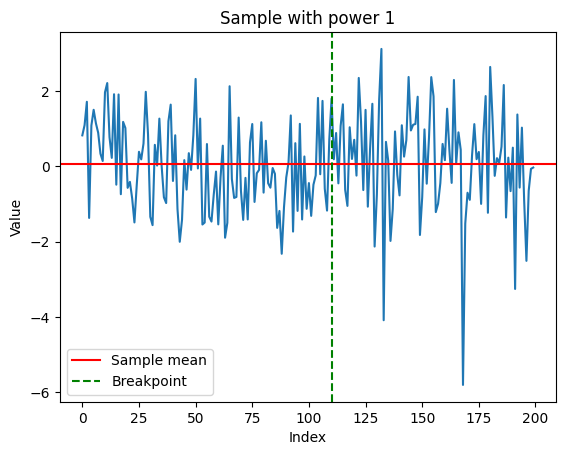

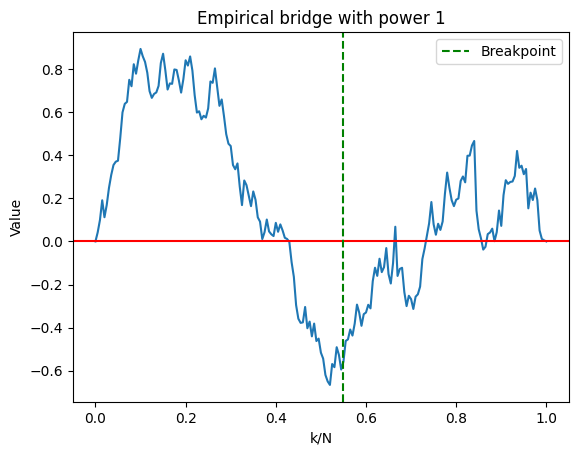

Absolute maximum of 1.346 is at the point 117
Test statistic                         = 1.3457
P-value using scipy.stats.kstwobign.sf = 0.0535
P-value using math formula             = 0.0535
Accept H0. There is no change-point in the sample



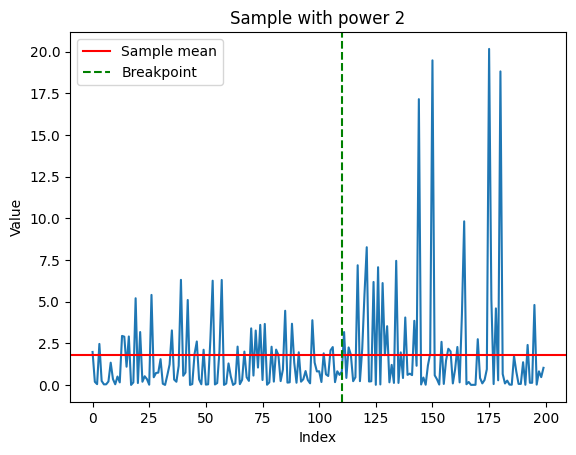

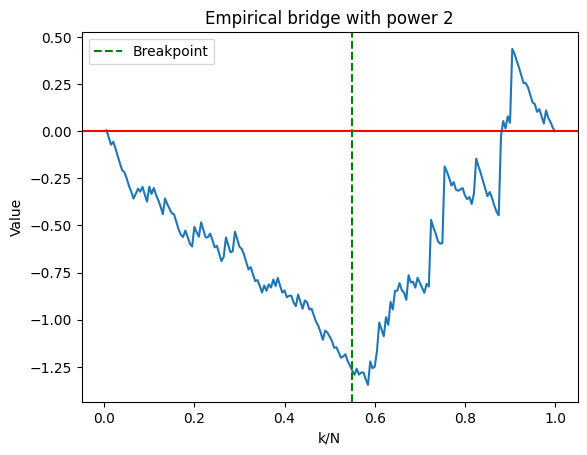

Absolute maximum of 1.604 is at the point 119
Test statistic                         = 1.6038
P-value using scipy.stats.kstwobign.sf = 0.0117
P-value using math formula             = 0.0117
Reject H0. There is a change-point in the sample



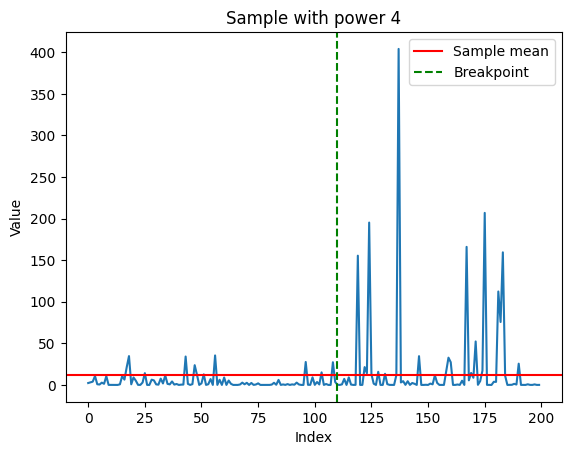

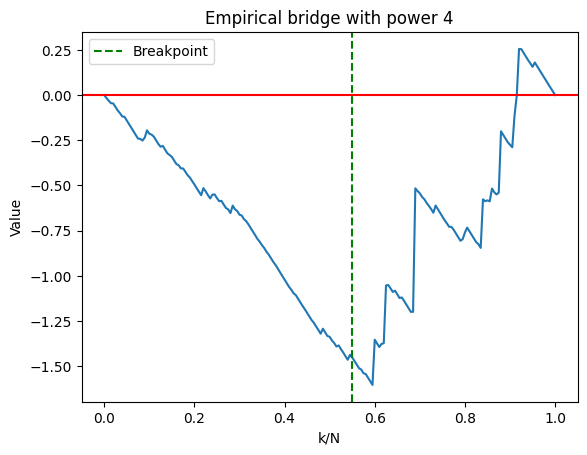

In [105]:
for power in [1, 2, 4]:
  sample = [x**power for x in generate_sample()]
  sample_mean = np.mean(sample)
  sample_empirical_bridge = empirical_bridge(sample)

  argmax = np.argmax(np.abs(sample_empirical_bridge))
  sample_empirical_bridge_abs_max = abs(sample_empirical_bridge[argmax])
  print(f"Absolute maximum of {sample_empirical_bridge_abs_max:0.3f} is at the point {argmax}")

  test_statistic = calculate_test_statistic(sample_empirical_bridge)
  analyze_statistic(test_statistic)
  print()

  plot_sample(sample, f"Sample with power {power}")
  plot_empirical_bridge(sample_empirical_bridge, f"Empirical bridge with power {power}")



In [106]:
power_original, mean_diff_original, variance_diff_original = calculate_power(lambda x: x)
power_squared, mean_diff_squared, variance_diff_squared = calculate_power(lambda x: x**2)
power_fourth, mean_diff_fourth, variance_diff_fourth = calculate_power(lambda x: x**4)

print_table(["Power of the test for original sample (power 1)", "Power of the test for sample with power 2", "Power of the test for sample with power 4"],
            [round(power_original, 4), round(power_squared, 4), round(power_fourth, 4)])

print("\nMean of the difference of means of cosine part of the sample and hypsecant part of the sample")
print_table(["for original sample (power 1)", "for sample with power 2", "for sample with power 4"],
            [round(mean_diff_original, 4), round(mean_diff_squared, 4), round(mean_diff_fourth, 4)])

print("\nMean of the difference of variances of cosine part of the sample and hypsecant part of the sample")
print_table(["for original sample (power 1)", "for sample with power 2", "for sample with power 4"],
            [round(variance_diff_original, 4), round(variance_diff_squared, 4), round(variance_diff_fourth, 4)])



Power of the test for original sample (power 1) = 0.05
Power of the test for sample with power 2       = 0.542
Power of the test for sample with power 4       = 0.348

Mean of the difference of means of cosine part of the sample and hypsecant part of the sample
for original sample (power 1) = -0.0066
for sample with power 2       = -1.181
for sample with power 4       = -25.1754

Mean of the difference of variances of cosine part of the sample and hypsecant part of the sample
for original sample (power 1) = -1.1626
for sample with power 2       = -21.6255
for sample with power 4       = -33841.8005


# Results
Our empirical bridge test detects mean shifts between segments of a time series. By applying different transformations to the data, we reveal how distributional differences translate into detectable breakpoints.

## Quantitative Results

| Transformation	| Power |	Mean Difference |	Variance Difference |
| --- | --- | --- | --- |
| x¹ (original) |	0.05	| -0.0066 |	-1.1626 |
|x² (squared) |	0.542	| -1.181 |	-21.6255 |
|x⁴ (4th power)	| 0.348 |	-25.1754 |	-33841.8005 |


## 1. Original data ($x$)


*   Power ≈ 0.05. Very low probability of rejecting $H_{0}$, when $H_{1}$ is true
*   Mean difference ≈ 0 — Cosine and hypsecant distributions have essentially identical means. That is probably why, $H_{0}$ would be accepted
*   Moderate variance difference (-1.1626) — but the test is insensitive to variance changes in raw data

The test falsely accepted $H_{0}$

## 2. Squared data ($x^2$)
* Power ≈ 0.542. More than 50% of correctly rejecting $H_{0}$!!!
* Mean difference = -1.181 — Mean shift is detectible
* Large variance difference (-22.6) amplifies the effect after transformation

The test correctly rejected $H_{0}$

## 3. Data powered to the 4-th power ($x^4$)
* Power ≈ 0.348. Less than 35% of correctly rejecting $H_{0}$
* Mean difference = -27.46 — Massive theoretical difference
* Extreme variance difference (-60,329) — indicates heavy-tailed, unstable data
* Strange: despite 23x larger mean difference than x², power is lower

The test falsely accepted $H_{0}$

## Conclusion
The squared transformation achieves the optimal balance for this test